# AI vision via Raku

Anton Antonov   
[RakuForPrediction-book at GitHub](https://github.com/antononcube/RakuForPrediction-book)   
November 2023

## Introduction

In the fall of 2023 OpenAI introduced the image vision model "gpt-4-vision-preview", [OAIb1].

The model "gpt-4-vision-preview" represents a significant enhancement to the GPT-4 model, providing developers and AI enthusiasts with a more versatile tool capable of interpreting and narrating images alongside text. This development opens up new possibilities for creative and practical applications of AI in various fields.

For example, consider the following Raku-developer-centric applications:

- Narration of UML diagrams
- Code generation from narrated (and suitably tweaked) narrations of architecture diagrams and charts
- Generating presentation content draft from slide images
- Extracting information from technical plots
- etc.

A more diverse set of the applications would be:

- Dental X-ray images narration
- Security or baby camera footage narration
    - How many people or cars are seen, etc.
- Transportation trucks content descriptions
    - Wood logs, alligators, boxes, etc.
- Web page visible elements descriptions
    - Top menu, biggest image seen, etc.
- Creation of recommender systems for image collections 
    - Based on both image features and image descriptions
- etc.

As a first concrete example, consider the following image that fable-dramatizes the release of Raku's 2023.11 version (https://i.imgur.com/UcRYl9Yl.jpg):

![](https://i.imgur.com/UcRYl9Yl.jpg)

Here is its narration:

In [134]:
#% bash
openai-playground --images=https://i.imgur.com/UcRYl9Yl.jpg Very concisely describe the image

The image depicts a vibrant, colorful illustration of two raccoons under a large tree adorned with various fruits, surrounded by butterflies, with a landscape of trees and a clear sky in the background. There's a date "2023.11" on the tree trunk.


### Ways to use with Raku

There are five ways to utilize image interpretation (or vision) services in Raku:

- Command Line Interface (CLI) script, [AAp1]
- Dedicated Web API functions, [AAp1]
- LLM functions, [AAp2]
- Dedicated notebook cell type, [AAp3, AAv1]
- Any combinations of the above

In this document are demonstrated the first three and the fifth. The fourth one is still "under design and consideration." 

**Remark:** Document's structure reflects the list of the "five ways" above.

**Remark:** The model "gpt-4-vision-preview" is given as a ["chat completion model"](https://platform.openai.com/docs/api-reference/chat/create),
therefore, in this document we consider it to be a Large Language Model (LLM).

**Remark:** This document was prepared as Jupyter chatbook, [AAp3], and then it was converted to Markdown and Mathematica / Wolfram Language notebook.

### Packages

Here are the Raku packages (namespaces) used below, [AAp1, AAp2, AAp3]:

In [135]:
use WWW::OpenAI;
use WWW::OpenAI::ChatCompletions;
use WWW::MermaidInk;
use Lingua::Translation::DeepL;
use Data::Translators;
use LLM::Functions;



**Remark:** The Jupypter kernel of "Jupyter::Chatbook", [AAp3], automatically loads the packages "Data::Translators" and "LLM::Functions". The functionalities of the packages "WWW::OpenAI" and "WWW::MermaidInk" are available in chatbooks through dedicated cells, [AAv1, AAv3].

### Images

Here are the links to all images used in this document:


| Name | Link |
| --- | --- |
| Raccoons chasing butterflies | https://i.imgur.com/UcRYl9Yl.jpg |
| LLM functionalities mind-map | https://imgur.com/kcUcWnq |
| Single sightseer | https://i.imgur.com/LEGfCeql.jpg |
| Three hunters | https://raw.githubusercontent.com/antononcube/Raku-WWW-OpenAI/main/resources/ThreeHunters.jpg |
| Raku Jupyter Chatbook solution | https://imgur.com/22lXXks |
| Cyber Week Spending Set to Hit New Highs in 2023 | https://cdn.statcdn.com/Infographic/images/normal/7045.jpeg |

-----

## CLI

The simplest way to use the OpenAI's vision service is through the CLI script of "WWW::OpenAI", [AAp1]. (Already demoed in the introduction.)

Here is an image that summarizes how Jupyter Chatbooks work (see [AAp3, AAv1, AAv2]):

![](https://imgur.com/22lXXks.jpg)

Here is a CLI shell command that requests the image above to be described (using at most 900 tokens):

In [110]:
#% bash
openai-playground --images=https://i.imgur.com/22lXXks.jpg --max-tokens=900 Describe the image

The image displays a flowchart with a structured sequence of operations or processes. The chart is divided into several areas with different headings that seem to be part of a software system or application. The main areas identified in the flowchart are "Message evaluation," "LLM interaction," "Chatbook frontend," "Chatbook backend," and "Prompt processing."

Starting from the left, the message evaluation feeds into "LLM interaction" where there are three boxes labeled "LLM::Functions," "PaLM," and "OpenAI," suggesting these are different functions or APIs that can be interacted with.

In the "Chatbook frontend," there is a process that begins with a "Chat cell" that leads to a decision point asking if "Chat ID specified?" Based on the answer, it either assumes 'NONE' for the chat ID or proceeds with the specified ID.

In the "Chatbook backend," there is a check to see if the "Chat ID exists in DB?" If not, a new chat object is created; otherwise, an existing chat object is retrieved 

Shell workflow pipelines can be constructed with commands using CLI scripts of the packages loaded above. 
For example, here is a pipeline that translates the obtained image description from English to Bulgarian using the package "Lingua::Translation::DeepL", [AAp5]:

In [161]:
#% bash
openai-playground --images=https://i.imgur.com/22lXXks.jpg --max-tokens=900 'Very concisely describe the image' | deepl-translation -t=Bulgarian

Изображението представлява блок-схема, която очертава процес, включващ оценка на съобщенията, взаимодействие с големи езикови модели (LLM) като PaLM и OpenAI и бекенд система за обработка на чат взаимодействия. Процесът включва стъпки за анализиране на подсказките, проверка за известни подсказки и управление на чат обекти в база данни. Изглежда, че това е системен дизайн за обработка и реагиране на потребителски входове в приложение за чат.



Of course, we can just request OpenAI's vision to give the image description in whatever language we want (say, by using emojis):

In [162]:
#% bash
openai-playground --images=https://i.imgur.com/22lXXks.jpg --max-tokens=900 Very concisely describe the image in 🇷🇺

Это изображение диаграммы потока данных или алгоритма, на котором представлены различные этапы взаимодействия и обработки сообщений в компьютерной системе. На диаграмме есть блоки с надписями и стрелки, указывающие направление потока данных.


-----

## Web API functions

Within a Raku script or REPL session OpenAI's vision service can be accessed with the functions `openai-completion` or `openai-playground`.

**Remark:** The function `openai-playground` is an umbrella function that redirects to various "specialized" functions for interacting with different OpenAI services.
`openai-completion` is one of them. Other specialized functions are those for moderation, vector embeddings, and audio transcription and processing; see [AAp1].

If the function `openai-completion` is given a list of images, a textual result corresponding to those images is returned.
The argument "images" is a list of image URLs, image file names, or image Base64 representations. (Any combination of those element types can be specified.)

Before demonstrating the vision functionality below we first obtain and show a couple of images.

### Images

Here is a URL of an image: (https://i.imgur.com/LEGfCeql.jpg). Here is the image itself:

![](https://i.imgur.com/LEGfCeql.jpg)

Next, we demonstrate how to display the second image by using the file path and the `encode-image` function from the `WWW::OpenAI::ChatCompletions` namespace. 
The `encode-image` function converts image files into Base64 image strings, which are a type of text representation of the image.

When we use the `openai-completion` function and provide a file name under the "images" argument, the `encode-image` function is automatically applied to that file.

Here is an example of how we apply `encode-image` to the 
[image](https://github.com/antononcube/Raku-WWW-OpenAI/blob/main/resources/ThreeHunters.jpg) 
from a given file path (`$*HOME ~ '/Downloads/ThreeHunters.jpg'`):

In [ ]:
#% markdown
my $img3 = WWW::OpenAI::ChatCompletions::encode-image($*HOME ~ '/Downloads/ThreeHunters.jpg');
"![]($img3)"

**Remark:** The "three hunters" image is a [resource file](https://github.com/antononcube/Raku-WWW-OpenAI/blob/main/resources/ThreeHunters.jpg) of "WWW::OpenAI", [AAp1].

### Image narration

Here is an image narration example with the two images above, again, one specified with a URL, the other with a file path:

In [27]:

my $url1 = 'https://i.imgur.com/LEGfCeql.jpg';
my $fname2 = $*HOME ~ '/Downloads/ThreeHunters.jpg';
my @images = [$url1, $fname2];

openai-completion("Give concise descriptions of the images.", :@images, max-tokens => 900, format => 'values');

1. The first image features a single raccoon perched on a tree branch surrounded by a multitude of colorful butterflies in an array of blues and oranges, set against a vibrant, nature-themed backdrop.

2. The second image depicts three raccoons on a tree branch in a forest setting, with two of them looking towards the viewer and one looking to the side. The background is filled with autumnal-colored leaves and numerous butterflies that match the whimsical atmosphere of the scene.

### Description of a mind-map

Here is an application that should be more appealing to Raku-developers -- getting a description of a technical diagram or flowchart. 
Well, in this case, it is a mind-map from [AA1]:

![](https://i.imgur.com/kcUcWnql.jpeg)

Here are get the vision model description of the mind-map above (and place the output in Markdown format):

In [93]:
#% markdown

my $mm-descr = 
    openai-completion(
        "How many branches this mind-map has? Describe each branch separately. Use relevant emoji prefixes.", 
        images => 'https://imgur.com/kcUcWnq.jpeg', 
        max-tokens => 1024,
        format => 'values'
    );

$mm-descr

The mind-map has five branches, each representing a different aspect or functionality related to LLM (Large Language Models) services access. Here's the description of each branch with relevant emoji prefixes:

1. 🎨 **DALL-E**: This branch indicates that DALL-E, an AI system capable of creating images from textual descriptions, is related to or a part of LLM services.

2. 🤖 **ChatGPT**: This branch suggests that ChatGPT, which is likely a conversational AI based on GPT (Generative Pre-trained Transformer), is associated with LLM services.

3. 🧠 **PaLM**: This branch points to PaLM, suggesting that it is another model or technology related to LLM services. PaLM might stand for a specific model or framework in the context of language processing.

4. 💬 **LLM chat objects**: This branch leads to a node indicating chat-related objects or functionalities that are part of LLM services.

5. 📚 **Chatbooks**: This branch leads to a concept called "Chatbooks," which might imply a feature or application related to creating books from chat or conversational content using LLM services.

Each of these branches emanates from the central node labeled "LLM services access," indicating that they are all different access points or functionalities within the realm of large language model services.

Here from the obtained description we request a (new) Mermaid-JS diagram to be generated:

In [104]:
my $mmd-chart = llm-synthesize(["Make the corresponding Mermaid-JS diagram code for the following description. Give the code only, without Markdown symbols.", $mm-descr], e=>'ChatGPT')

graph LR
A[LLM services access] 
B[DALL-E]-->A 
C[ChatGPT]-->A 
D[PaLM]-->A 
E[LLM chat objects]-->A 
F[Chatbooks]-->A

Here is a diagram made with Mermaid-JS spec obtained above using a function of "WWW::MermaidInk", [AAp4]:

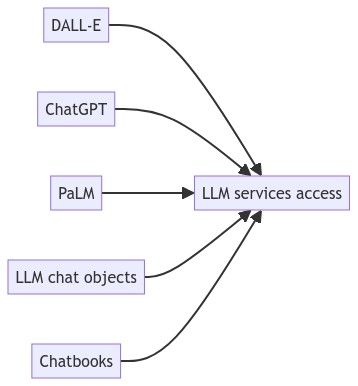

In [105]:
#% markdown 
mermaid-ink($mmd-chart, format=>'md-image')

**Remark:** In a Jupyter chatbook, [AAp3], Mermaid-JS diagrams can be "directly" visualized with notebook cells that have the magic `mermaid`. 
Below is given an instance of one of the better LLM results for making a Mermaid-JS diagram over the "vision-derived" mind-map description.

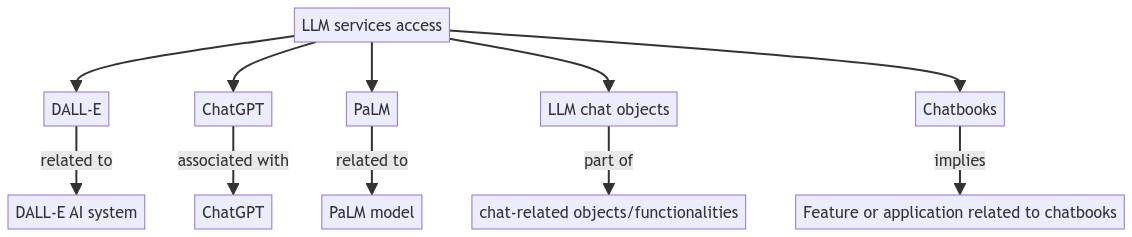

In [101]:
#% markdown 
mermaid-ink('
graph TB
    A[LLM services access] --> B[DALL-E]
    A --> C[ChatGPT]
    A --> D[PaLM]
    A --> E[LLM chat objects]
    A --> F[Chatbooks]
    B -->|related to| G[DALL-E AI system]
    C -->|associated with| H[ChatGPT]
    D -->|related to| I[PaLM model]
    E -->|part of| J[chat-related objects/functionalities]
    F -->|implies| K[Feature or application related to chatbooks]
', format => 'md-image')

Here is an example of code generation based on the "vision derived" mind-map description above:

In [119]:
#% markdown
llm-synthesize([
    "Generate Raku code -- using Markdown markings -- with an object oriented hierarchy corresponding to the description:\n", 
    $mm-descr], 
    e=>'ChatGPT')

```raku
class LLM::ServiceAccess {
    has DALLE $.dalle;
    has ChatGPT $.chatgpt;
    has PaLM $.palm;
    has LLMChatObjects $.llm-chat-objects;
    has Chatbooks $.chatbooks;
}

class DALLE {
    # Implementation for DALL-E functionality
}

class ChatGPT {
    # Implementation for ChatGPT functionality
}

class PaLM {
    # Implementation for PaLM functionality
}

class LLMChatObjects {
    # Implementation for LLM chat objects
}

class Chatbooks {
    # Implementation for Chatbooks functionality
}

# Usage
my $llm-service-access = LLM::ServiceAccess.new(
    dalle => DALLE.new,
    chatgpt => ChatGPT.new,
    palm => PaLM.new,
    llm-chat-objects => LLMChatObjects.new,
    chatbooks => Chatbooks.new,
);
```


------

## LLM Functions

Let us show programmatic utilizations of the vision capabilities.

Here is the workflow we consider:

1. Ingest an image file and encode it into a Base64 string
2. Make an LLM configuration with that image string (and a suitable model)
3. Synthesize a response to a basic request (like, image description)
   - Using `llm-synthesize`
4. Make an LLM function for asking different questions over image
   - Using `llm-function`
5. Ask questions and verify results
   - ⚠️ *Answers to "hard" numerical questions are often wrong.*

### Image ingestion and encoding

Here we ingest an image and display it:

In [ ]:
#%markdown
my $imgBarChart = WWW::OpenAI::ChatCompletions::encode-image($*HOME ~ '/Downloads/Cyber-Week-Spending-Set-to-Hit-New-Highs-in-2023-small.jpeg');
"![]($imgBarChart)"

**Remark:** The image was downloaded from the post ["Cyber Week Spending Set to Hit New Highs in 2023"](https://www.statista.com/chart/7045/thanksgiving-weekend-e-commerce-sales/).

### Configuration and synthesis

Here we make a suitable LLM configuration with the image:

In [146]:
my $confImg = llm-configuration("ChatGPT", model => 'gpt-4-vision-preview', images => $imgBarChart, temperature => 0.2);
$confImg.WHAT

(Configuration)

Here we synthesize a response of a image description request:

In [147]:
llm-synthesize("Describe the image.", e=> $confImg)

The image is a bar chart titled "Cyber Week Spending Set to Hit New Highs in 2023". It shows estimated online spending on Thanksgiving weekend in the United States for the years 2019, 2020, 2021, 2022, and a forecast for 2023. The spending is broken down by three days: Thanksgiving Day, Black Friday, and Cyber Monday.

Each year is represented by a different color, with bars for each day showing the progression of spending over the years. The spending amounts range from $0B to $12B. The chart indicates an overall upward trend in spending, with the forecast for 2023 showing the highest spending across all three days.

In the top left corner of the chart, there is a small illustration of a computer with coins, suggesting online transactions. At the bottom, there is a note indicating that the forecast is based on data from Adobe Analytics. The Statista logo is visible in the bottom right corner, and there are Creative Commons and share icons in the bottom left corner.

### Repeated questioning

Here we define an LLM function that allows the multiple question request invocations over the image: 

In [148]:
my &fst = llm-function({"For the given image answer the question: $_ . Be as concise as possible in your answers."}, e => $confImg); 

-> **@args, *%args { #`(Block|3507398517968) ... }

In [150]:
&fst('How many years are presented in that image?')

Five years are presented in the image.

In [151]:
&fst('Which year has the highest value? What is that value?')

The year with the highest value is 2023, with a value of just over $11 billion.

**Remark:** Numerical value readings over technical plots or charts seem to be often wrong. OpenAI's vision model warns about this in the responses often enough.

______

## Dedicated notebook cells

In the context of the "recently-established" notebook solution "Jupyter::Chatbook", [AAp3], I am contemplating an extension to integrate OpenAI's vision service. 

The main challenges here include determining how users will specify images in the notebook, such as through URLs, file names, or Base64 strings, each with unique considerations. Additionally, I am exploring how best to enable users to input prompts or requests for image processing by the AI/LLM service. 

This integration, while valuable, it is not my immediate focus as there are programmatic ways to access OpenAI's vision service already. (See the previous section.)

-------

## Combinations (fairytale generation)

Consider the following computational workflow for making fairytales:

1. Draw or LLM-generate a few images that characterize parts of a story.
2. Narrate the images using the LLM "vision" functionality.
3. Use an LLM to generate a story over the narrations.

**Remark:** Multi-modal LLM / AI systems already combine steps 2 and 3.

**Remark:** The workflow above (after it is programmed) can be executed multiple times until satisfactory results are obtained.

Here are image generations using DALL-E for four different requests with the same illustrator name in them:

In [152]:
my @story-images = [
"a girl gets a basket with wine and food for her grandma.",
"a big bear meets a girl carrying a basket in the forest.",
"a girl that gives food from a basket to a big bear.",
"a big bear builds a new house for girl's grandma."
].map({ openai-create-image( 'Painting in the style of John Bauer of ' ~ $_, response-format => 'b64_json', format => 'values') });

@story-images.elems

4

Here we display the images:

In [ ]:
#% markdown
@story-images.map({ '![](data:image/jpeg;base64,' ~ $_ ~ ')' }).join(' ' x 5)

Here we get the image narrations (via the OpenAI's "vision service"):

In [157]:
my $story-images-descriptions = 
    openai-completion("Consisely describe the images.",
        images => @story-images.map({ 'data:image/jpeg;base64,' ~ $_ ~ '' }).List,
        max-tokens => 900,
        format => 'values'
    );

$story-images-descriptions 

1. The first image features a stylized painting of a woman in a red hood, carrying a large basket with a girl in white looking up at her.
2. The second image shows a dark, fairy tale-like forest scene where a young girl holding a basket is facing a large black bear.
3. The third image is an illustration of a girl offering a basket to a seated, gentle-looking bear in a green forest setting.
4. The final image depicts a bear on two legs, dressed in a blue dress, standing by a yellow house with a girl in blue in front of the door.

Here we extract the descriptions into a list:

In [158]:
#% markdown
my @descr = $story-images-descriptions.split("\n", :skip-empty).grep({ $_ ~~ / ^ \d /});
@descr ==> to-html()

<ul><li>1. The first image features a stylized painting of a woman in a red hood, carrying a large basket with a girl in white looking up at her.</li><li>2. The second image shows a dark, fairy tale-like forest scene where a young girl holding a basket is facing a large black bear.</li><li>3. The third image is an illustration of a girl offering a basket to a seated, gentle-looking bear in a green forest setting.</li><li>4. The final image depicts a bear on two legs, dressed in a blue dress, standing by a yellow house with a girl in blue in front of the door.</li></ul>

Here we generate the story from the descriptions above (using Google's PaLM):

In [160]:
my $res = llm-synthesize(['Write a story that fits the following four descriptions:',|@descr], e=>llm-configuration('PaLM', max-tokens=>1200))

Once upon a time, there was a little girl named Gretel who lived with her mother in a small village on the edge of a dark and mysterious forest. One day, Gretel's mother fell ill and could not work. The little girl knew that they needed money to buy food, so she decided to go into the forest and find berries to sell at the market.

Gretel walked for a long time, but she could not find any berries. She was about to give up when she saw a large black bear sitting under a tree. The bear was licking its paws and looked very friendly.

Gretel was scared, but she knew that she had to do something. She walked up to the bear and said, "Hello, Mr. Bear. I am Gretel. I am looking for berries to sell at the market. Do you know where I can find some?"

The bear smiled and said, "Of course I do, Gretel. I know where all the best berries are. Follow me."

The bear led Gretel through the forest to a clearing. The clearing was full of beautiful berries. Gretel picked as many as she could carry and tha

-----

## References

### Articles

[AA1] Anton Antonov,
["Workflows with LLM functions"](https://rakuforprediction.wordpress.com/2023/08/01/workflows-with-llm-functions/),
(2023),
[RakuForPrediction at WordPress](https://rakuforprediction.wordpress.com).

[AA2] Anton Antonov,
["Re-programming to Python of LLM- and Chatbook packages"](https://rakuforprediction.wordpress.com/2023/10/15/re-programming-to-python-of-llm-and-chatbook-packages/),
(2023),
[RakuForPrediction at WordPress](https://rakuforprediction.wordpress.com).

[OAIb1] OpenAI team,
["New models and developer products announced at DevDay"](https://openai.com/blog/new-models-and-developer-products-announced-at-devday),
(2023),
[OpenAI/blog](https://openai.com/blog).

### Packages

[AAp1] Anton Antonov,
[WWW::OpenAI](https://github.com/antononcube/Raku-WWW-OpenAI) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


[AAp2] Anton Antonov,
[LLM::Functions](https://github.com/antononcube/Raku-LLM-Functions) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


[AAp3] Anton Antonov,
[Jupyter::Chatbook](https://github.com/antononcube/Raku-Jupyter-Chatbook) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).

[AAp4] Anton Antonov,
[WWW::MermaidInk](https://github.com/antononcube/Raku-WWW-MermaidInk) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).

[AAp5] Anton Antonov,
[Lingua::Translation::DeepL](https://github.com/antononcube/Raku-Lingua-Translation-DeepL) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


### Videos

[AAv1] Anton Antonov,
["Jupyter Chatbook LLM cells demo (Raku)"](https://www.youtube.com/watch?v=cICgnzYmQZg)
(2023),
[YouTube/@AAA4Prediction](https://www.youtube.com/@AAA4prediction).

[AAv2] Anton Antonov,
["Jupyter Chatbook multi cell LLM chats teaser (Raku)"](https://www.youtube.com/watch?v=wNpIGUAwZB8)
(2023),
[YouTube/@AAA4Prediction](https://www.youtube.com/@AAA4prediction).
